In [1]:
# default_exp data.core_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [4]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [5]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [6]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [7]:
# export

class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = {}, {}

    def encodes(self, o):
        for i in range(len(o)-1):
            if type(o[i]) == TensorCon and o[i].shape[-1]>0:
                self.m[i] = torch.mean(o[i])
                self.s[i] = torch.std(o[i]) +self.eps
            elif type(o[i]) == TensorSeqs :
                self.m[i] = torch.mean(o[i], -1, keepdim=True)
                self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            else:
                print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                self.m[i], self.s[i] = 0, 1
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0]         
            
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
            
        return TSMulti([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])              

    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

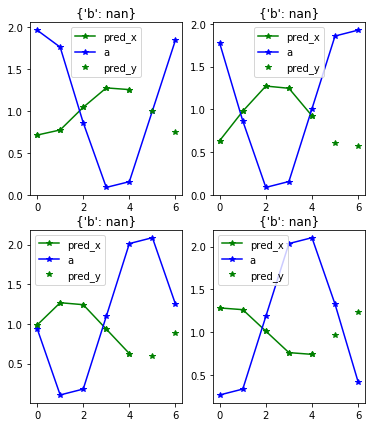

In [8]:
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        test_close(a.mean(),0)
        test_close(a.std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti)

dl.show_batch(max_n = 4)

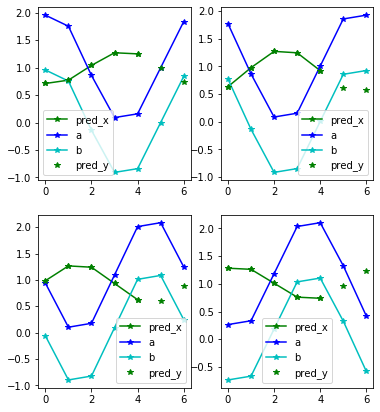

In [9]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            test_close(a[i].mean(),0)
            test_close(a[i].std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [10]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [11]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [12]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [13]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[-1.8903522707765108, -1.727658003969936, -1.441657594610698, -1.0327270453700568, -0.7249681004874339, -0.5541974467682991, -0.19727177206466898, 0.06671742961831297, 0.1438909712967569, 0.32618491800635335, 0.3568660691497019, 0.4683879716374947, 0.4895663013970353, 0.5491161029112941, 0.5041227688087574, 0.5991337928446407, 0.5953060340450099, 0.7683267943253805, 0.9358028604753474, 1.0189036844251766, 1.0269039115012224, 1.3806245633558725, 1.0870604070012837, 1.4191125673495097, 1.170418772815877, 1.0522615841862282, 1.153820590074516, 0.9584213379430458, 1.1299151586479677, 0.9570414...","[8.797299575833952, 8.451169567177864, 8.343310867698285, 8.560123965787316, 9.098803044371191, 9.862190454930369, 10.681135694957147, 11.358437522042776, 11.722000986405366, 11.671995858683204, 11.208422138876339, 10.43111005634647, 9.51215456087528, 8.648756894871754, 8.010067560843655, 7.6932442073103475, 7.701092651345569, 7.947212404557341, 8.286447686022797, 8.56106694675753, 8.648640821346094, 8.497359040361946, 8.138552161467562, 7.673222905337378, 7.237307777127511, 6.956794176193094, 6.9067890484709284, 7.08729239396099, 7.4231972667265325, 7.788516267412472, 8.04731289086256, 8....",0,-0.391830
1,"[-0.14575965567174784, -0.4416116277915244, -0.5855448499130984, -0.7937585084082565, -0.661806001202089, -0.7646469956355723, -0.8844193639676879, -0.7480012147810086, -0.9055126444924176, -0.8416817145232457, -0.8803593705926084, -1.158621699015483, -1.2873594348010025, -1.2075260296801236, -1.3456724653981535, -1.4686176880279638, -1.2992519386592414, -1.1281163761586896, -1.1123317884638764, -1.1158430744329018, -1.030412281066063, -0.9318281749575453, -1.0848871742230901, -1.1285102817558965, -1.2769529729121616, -1.3609405366576355, -1.4051780724601777, -1.3223863675170195, -0.993562...","[-0.6188618981189268, -0.709164518067876, -0.7812137756896488, -0.7247783435802527, -0.48377284958728695, -0.07791899860256668, 0.4010099611763378, 0.8175353830567023, 1.0368132687051217, 0.971189981228739, 0.6142078678246048, 0.05084103804501083, -0.5602123701834536, -1.0279096413849538, -1.1823380454216157, -0.9247608434323475, -0.25934784409861633, 0.7032138617071971, 1.7719731233979117, 2.7249036453059157, 3.367376817981169, 3.5834864032357157, 3.3657887953741428, 2.815216313177576, 2.111494071859012, 1.4628242054565033, 1.0494227310341533, 0.9770128636842039, 1.2531828740255961, 1.792...",0,0.787969
2,"[-1.3638975930690702, -1.564861885903632, -1.3723559417274478, -1.3001947479412563, -1.4235864063821644, -1.4396500601137445, -1.3311805040847136, -1.3641249540671514, -1.3235270950225761, -1.1405685676097732, -1.3177752572315296, -1.333419282610257, -1.1960196956891609, -1.0779365784144126, -0.999607346035401, -0.9954705111418674, -1.0516368101829154, -0.9484340939752929, -0.8147371298028642, -0.9468406735845557, -0.675270897081016, -0.7561073978107683, -0.5976963988873606, -0.7231517039035295, -0.6872854530103458, -0.632110197138083, -0.5942444134076034, -0.560697070287258, -0.3923813638...","[6.662720172553351, 6.64888250310189, 6.70824927912937, 6.801303016746544, 6.876154646127349, 6.884992550993674, 6.799495881168266, 6.620447547648175, 6.378514693358918, 6.125825755377046, 5.920764174908859, 5.810478719190545, 5.816349723472267, 5.9268203880771555, 6.0998437954586695, 6.27434968673113, 6.387448427375315, 6.392365733941467, 6.271857737620353, 6.043168307221209, 5.753071726193751, 5.464457629057255, 5.238396274697405, 5.1169345806607005, 5.111629346624029, 5.201100237337265, 5.338198485564122, 5.4645406500983995, 5.5279982938635355, 5.497904273933973, 5.373475679312676, 5.18...",0,-1.204997
3,"[-1.5049858373216602, -1.2452731039589484, -1.2889321286250717, -1.1401964175245258, -1.1142670346802215, -0.9685001372425461, -0.7735843325396453, -0.39902133073018564, -0.4070222713450481, -0.23661491884881236, -0.09926162787757459, -0.1809255610748809, 0.20021854478001846, 0.4029644023683371, -0.02822360321610583, 0.11

In [14]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [15]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [16]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [17]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [18]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [19]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [20]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [21]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [22]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df['city'] = df['city'].astype(float)
df.head(3)

,x,weather,city,cont
0,"[[-2.8178253012270797, -2.5333278283063763, -2.3358004843091433, -2.1296874481390757, -1.9592605568205388, -1.69863157796189, -1.5626014378393864, -1.2389415866346625, -0.9288849920451414, -0.7559823474327232, -0.46980639929090956, -0.30267335489561986, -0.23014363536638985, -0.35271006734486726, -0.3063641236329724, -0.3295964943802932, -0.08367302824278738, -0.1549831702915016, -0.24472233821906342, -0.17336876017510347, -0.3300789764990613, -0.2863369526000308, -0.1542337584329873, -0.2012956076936165, -0.2301640523732122, -0.2661156958540483, -0.0379787843570162, -0.1369705617827852, 0...","[[3.2839214917807666, 3.1636406113078355, 3.135840742504744, 3.2202097318826546, 3.418081765981174, 3.714057322885467, 4.079823090083207, 4.479000180241702, 4.871945473775442, 5.219802423689879, 5.487583760726427, 5.646487382042647, 5.675854404294652, 5.5651146115844154, 5.315770460380585, 4.943073716946804, 4.47671877234845, 3.9597687343584145, 3.445230519875505, 2.9901873283484557, 2.6480618985193263, 2.460231433839365, 2.4486392410611586, 2.6110910379791856, 2.9205269573677284, 3.3287879597428778, 3.774423196629228, 4.1931543749960145, 4.528966232813299, 4.743603541084925, 4.82258233322...",0.0,1.038703
1,"[[-2.458638869726063, -2.3853893346673782, -2.2106523376198046, -2.0014297840090127, -1.952910174098536, -1.7440558069403986, -1.6927655943231243, -1.564679518134607, -1.3857833343138641, -1.2733167878680727, -1.1700978994145093, -0.9499304098091433, -0.889406862445222, -0.7597989033290163, -0.6266407386075561, -0.5853221021217988, -0.4598969428002061, -0.421019019712162, -0.30401192840018126, -0.1818731102868845, -0.11957115400027904, 0.017263623200323718, 0.058086570125115956, 0.08359718243532195, 0.23028858111224068, 0.24340076485066706, 0.3876387241646913, 0.30596176183270873, 0.418745...","[[2.381353012607338, 2.303225845046678, 2.2899620681524326, 2.373082519386859, 2.569848323888526, 2.88036151229558, 3.2870447292113054, 3.7565875492162633, 4.2441111011802395, 4.6989999237889, 5.071621235897531, 5.320028118649297, 5.415741307469779, 5.347824759258158, 5.124696758827607, 4.7734205861272265, 4.3365559820536825, 3.8669793911910015, 3.421353187997229, 3.0531051143618613, 2.805844572215829, 2.7080834151790802, 2.7699534363187537, 2.982344525084801, 3.3185626414542893, 3.7382691271738415, 4.1931579497824725, 4.633596328135514, 5.015327914522826, 5.305333231492959, 5.486059850548...",0.0,-0.430821
2,"[[0.17333516135836133, 0.2809039297595378, 0.23747314465703445, 0.0024219852326055756, -0.5543364464875203, -0.2913269991866093, -0.460969189305832, -0.4408823741313271, -0.4900852577424977, -0.384312002457113, -0.4857457464049592, -0.0870528139581962, -0.19446673214779012, 0.09717120919615518, -0.21596616504843638, 0.19461343290891994, 0.26528648615409145, 0.5369283728103572, 0.8905340659606079, 0.7031651905688472, 0.648758915994686, 0.5750826084319005, 0.6389375257728191, 0.5988272274941788, 0.3943792410110292, 0.45952819657555105, -0.2616299380868291, -0.4941207225289037, -0.78497877201...","[[-0.77060555255883, -0.65585798989803, -0.42589901435738975, -0.10463194534340925, 0.2717082337583532, 0.6594486108742288, 1.013376614018099, 1.2928462196695714, 1.4672674234779204, 1.520237589854515, 1.4517567187993543, 1.2782274459010696, 1.0302397755103865, 0.7484397311476452, 0.47803988479911896, 0.26271314853830396, 0.13869450575085485, 0.12988727584324655, 0.24463483850403156, 0.4745938140446241, 0.7958608830586545, 1.1722010621604158, 1.5599414392762665, 1.9138694424201224, 2.1933390480716404, 2.3677602518799965, 2.4207304182565963, 2.352249547201459, 2.1787202743031475, 1.93073260...",0.0,0.285147


Train:130; Valid: 60; Test 10


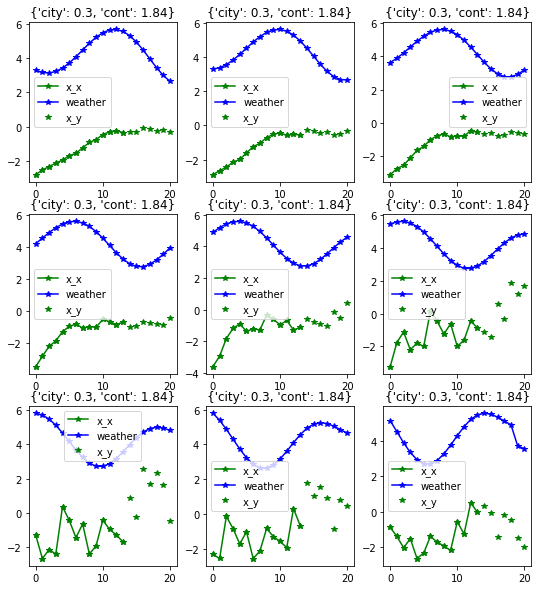

In [23]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=14, step=2, bs=32)
dbunch.train.show_batch(max_n=9)

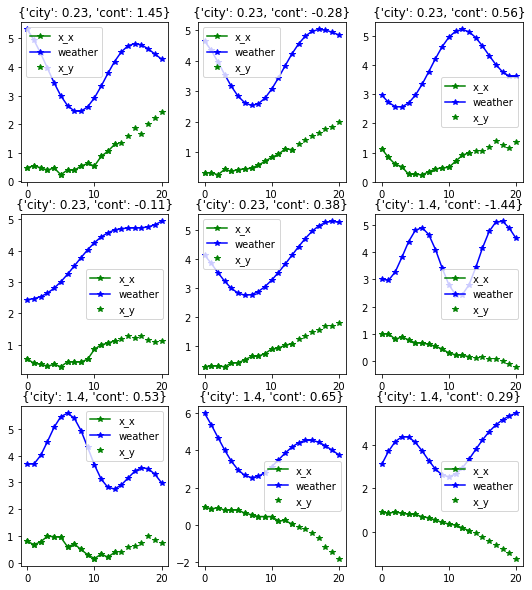

In [24]:
dbunch.test.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
